In [897]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

In [985]:
## parameters, UD=underdamped, OD=overdamped
N   = 2**12            # # of data points
m   = 1                # mass
T   = 1                # temperature
k   = 1                # stiffness
k_B = 1                # Boltzmann constant
f_s = 1                # sampling frequency
dt  = 1/f_s            # step size
g_c = np.sqrt(4*m*k)   # gamma critical
g_f = 10.500               # <1 for UD and >1 for OD
g   = g_c*g_f          # gamma
w0  = np.sqrt(k/m)     # frequency of UD motion
tau = m/g              # relaxation time
D   = k_B*T/g          # diffusion constant

if g_f >1:
    w = 1j*np.sqrt(-(w0**2)+(1/(4*tau*tau))) 
else:
    w = np.sqrt((w0**2)-(1/(4*tau*tau)))

params = (N, dt, w, w0, tau)

In [986]:
def calcVarM(params):
    N, dt, w, w0, tau = params
    tt   = 2*w*dt;  w02  = w0*w0;  w2 = w*w
    tau2 = tau*tau; tau3 = tau2*tau; dtbt=-dt/tau
    wt2=w2*tau2; dd=D/(wt2); dd1=dd/(4*w02*tau); dd2=dd/(4*tau)

    ss1 = np.cos(tt) - (2*w*tau*np.sin(tt)) - (4*w02*tau2)
    ss2 = np.cos(tt) + (2*w*tau*np.sin(tt)) - (4*w02*tau2)

    sigma2_xx = dd1*(4*w2*tau2 + np.exp(dtbt)*ss1)
    sigma2_vv = dd2*(4*w2*tau2 + np.exp(dtbt)*ss2)
    sigma2_xv = dd*np.exp(dtbt)*np.sin(w*dt)*np.sin(w*dt)
    return np.real(sigma2_xx), np.real(sigma2_vv), np.real(sigma2_xv)    


def calcExpM(params):
    N, dt, w, w0, tau = params
    I = np.eye(2)
    J11 =(1/(2*w*tau))
    J12 = (1/w)
    J21 = -(w0**2)/w
    J22 = -J11
    J = np.matrix([[J11,J12],[J21,J22]])
    return np.real(np.exp(-dt/(2*tau))*((np.cos(w*dt)*I)+(np.sin(w*dt)*J)))


def calcXV(params, sigma_matrix, expM):
    N, dt, w, w0, tau = params
    x = np.zeros([N,1])
    v = np.zeros([N,1])
    
    sigma2_xx, sigma2_vv, sigma2_xv = sigma_matrix

    for j in np.arange(0,N-1):
        oldvec = np.array([x[j],v[j]])
        randgauss = np.random.randn(2,1)
        delx = np.sqrt(sigma2_xx)*randgauss[0]
        delv = (sigma2_xv/(np.sqrt(sigma2_xx)))*randgauss[0]+(np.sqrt(sigma2_vv - ((sigma2_xv**2)/(sigma2_xx))))*randgauss[1]
        delvec = np.array([delx,delv])
        updatevec = np.dot(expM,oldvec)+delvec
        x[j+1] = updatevec[0]
        v[j+1] = updatevec[1]
    return x,v

In [987]:
#Estimate of evidence
def estimatorUD(x,v):
  
    # matrix sufficient statistics
    T1_11 = np.sum(x[1:]**2)
    T1_12 = np.sum(x[1:]*v[1:])
    T1_21 = T1_12
    T1_22 = np.sum(v[1:]**2)

    T2_11 = np.sum(x[1:]*x[:-1])
    T2_12 = np.sum(x[1:]*v[:-1])
    T2_21 = np.sum(v[1:]*x[:-1])
    T2_22 = np.sum(v[1:]*v[:-1])

    T3_11 = np.sum(x[:-1]*x[:-1])
    T3_12 = np.sum(x[:-1]*v[:-1])
    T3_21 = T3_12
    T3_22 = np.sum(v[:-1]*v[:-1])

    T1 = np.asanyarray([[T1_11, T1_12],[T1_21, T1_22]])
    T2 = np.asanyarray([[T2_11, T2_12],[T2_21, T2_22]])
    T3 = np.asanyarray([[T3_11, T3_12],[T3_21, T3_22]])

    invT3 = np.linalg.inv(T3)
    L = np.dot(T2, invT3) 
    
    S  = (1/N)*(T1 - np.dot(L, np.transpose(T2)))
    S2 = np.dot(S,S); iS=np.linalg.inv(S); iS2=np.dot(iS,iS)  
    L_t  = L.transpose(); eps  = np.asanyarray([[1,0],[0,-1]])
    L_te = np.dot(eps, L_t); Lte2 = np.dot(L_te, L_te)
    cc   = np.dot(S, np.linalg.inv(np.eye(2)  - Lte2))

    aa = np.dot(L, cc) + np.dot(cc, L.transpose()); aa2=np.dot(aa,aa)
    A1   = 0.5*N*S2;    A2 =0.5*N*(aa)
    A3   = np.dot(iS, T3-N*cc) - 0.5*N*np.dot(iS2,aa2)
    
    detA = np.linalg.det(A3)*(np.linalg.det(A1- np.dot(np.dot(A2, np.linalg.inv(A3)), A2)) )
    
    p=2; detS=np.linalg.det(S);
    ev0 = -0.5*N*(np.log(detS*(2*np.pi)**p) -np.sum(S*iS)) - 0.5*np.log(np.linalg.det(cc)*(2*np.pi)**p)
    ev1 = -0.5*np.log(np.abs(detA))
    evidence = 0.5*p*np.log(2*np.pi) + ev0 + ev1 
    print ev0, ev1

    return evidence

In [988]:
def estimatorOD(x):
    T1_11 = np.sum(x[1:]**2)
    T2_11 = np.sum(x[1:]*x[:-1])
    T3_11 = np.sum(x[:-1]**2)
    
    T1 = T1_11
    T2 = T2_11
    T3 = T3_11

    invT3 = 1.0/(T3)
    L = T2*invT3 
    
    S  = (1/N)*(T1 - L*T2)
    S2 = S*S; iS=1/(S);  
    cc   = 1; p=1

    A1   = 0.5*N*S2;    A2 =0.5*N*(2L*cc)
    A3   = iS*(T3-N*cc) -0.5*N*iS*iS*(2L*cc)*(2L*cc)
    detA = A1*A3 - A2*A2

    ev0 = -0.5*N*( np.log(S*(2*np.pi)) -1) - 0.5*np.log(cc*(2*np.pi))
    ev1 = -0.5*np.log(np.abs(detA))
    evidence = 0.5*p*np.log(2*np.pi) + ev0 + ev1 
    print ev0, ev1
    return evidence

In [989]:
params = (N, dt, w, w0, tau)
varM   = calcVarM(params)
expM   = calcExpM(params)
x, v   = calcXV(params, varM, expM)

In [990]:
x1 = estimatorUD(x, v)
x2 = estimatorOD(x)
print g_f, x1, x2, x1/x2

1699.51869569 -14.1860303579
3335.08473797 -8.66546911272
10.5 1687.1705424 3327.33820739 0.507063134926


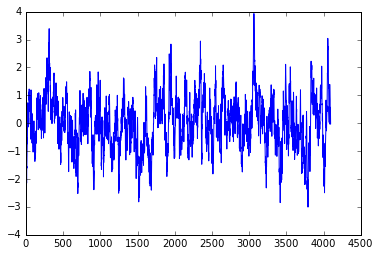

In [991]:
plt.plot(x)

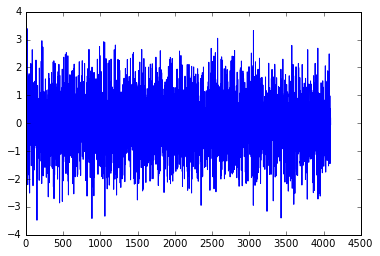

In [992]:
plt.plot(v)

In [993]:
S = ([1, 2], [3, 4])

In [994]:
np.sum(S)

10